In [ ]:
import numpy as np
import cv2
import pandas as pd
from scipy import ndimage as nd
 
import pickle
from matplotlib import pyplot as plt
import os
from skimage.io import imread, imshow
from skimage.filters import roberts, sobel, scharr, prewitt
import glob

In [ ]:
source_paths = "S1Hand/"
label_path = "S1OtsuLabelHand/"

sources = []
label = []

for file in os.listdir(source_paths):
    if file.endswith("tif"):
      sources.append(file)

       
for file in os.listdir(label_path):
    if file.endswith("tif"):
      label.append(file)


## Sanity Check
sources = sorted(sources)
label = sorted(label)
print(len(sources))
print(len(label))

577
577


In [ ]:
####################################################################
## STEP 1:   READ TRAINING IMAGES AND EXTRACT FEATURES  - Sentinel 1
################################################################
image_dataset_s1 = pd.DataFrame()  #Dataframe to capture image features

img_path = "S1Hand/" ## CHANGE ME!!!
for image in os.listdir(img_path):
  df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
  img = imread(img_path+image)

  vv = imread(img_path + image)[0:1,:,:].reshape((128,128)) 
  vh = imread(img_path + image)[1:2:,:,:].reshape((128,128))
  vv_vh = (vv/vh)
 
  #Add pixel values to the data frame
  vv_values = vv.reshape(-1)
  df['VV'] = vv_values   #Pixel value itself as a feature
            
  vh_values = vh.reshape(-1)
  df['VH'] = vh_values   
  # df['Image_Names1']=image          
  vv_vh_values = vv_vh.reshape(-1)
  df['VV/VH'] = vv_vh_values   

  #MEDIAN with sigma=3
  median_img = nd.median_filter(vh, size=3)
  median_img1 = median_img.reshape(-1)
  df['Median_s3'] = median_img1

  #VARIANCE with size=3
  variance_img = nd.generic_filter(vh, np.var, size=3)
  variance_img1 = variance_img.reshape(-1)
  df['Variance_s3'] = variance_img1  

  #ROBERTS EDGE
  edge_roberts = roberts(vh)
  edge_roberts1 = edge_roberts.reshape(-1)
  df['Roberts'] = edge_roberts1

  ######################################                    
  #Update dataframe for images to include details for each image in the loop
  image_dataset_s1 = image_dataset_s1.append(df)

In [ ]:
###########################################################
# STEP 2: READ LABELED IMAGES (MASKS) AND CREATE ANOTHER DATAFRAME
    # WITH LABEL VALUES AND LABEL FILE NAMES
##########################################################
mask_dataset = pd.DataFrame()  #Create dataframe to capture mask info.

mask_path = "S1OtsuLabelHand/" ### CHANGE ME!!!
for mask in label:   #os.listdir(mask_path):
    df2 = pd.DataFrame()  #Temporary dataframe to capture info for each mask in the loop
    input_mask = imread(mask_path + mask)
    label = input_mask
    #Add pixel values to the data frame
    label_values = label.reshape(-1)
    df2['Label_Value'] = label_values
    df2['Mask_Name'] = mask
    mask_dataset = mask_dataset.append(df2)  #Update mask dataframe with all the info from each mask

In [ ]:
################################################################
 #  STEP 3: GET DATA READY FOR RANDOM FOREST (or other classifier)
 # COMBINE BOTH DATAFRAMES INTO A SINGLE DATASET
###############################################################
dataset = pd.concat([image_dataset_s1, mask_dataset], axis=1)    #Concatenate both image and mask datasets

##If we do not want to include pixels with value 0 
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
# dataset.fillna(-1, inplace=True)
dataset.fillna(999, inplace=True)
# dataset = dataset[dataset.Label_Value != -1]
dataset.dropna()
# dataset = dataset.reset_index()

#Assign training features to X and labels to Y
#Drop columns that are not relevant for training (non-features)
X = dataset.drop(labels = ["Mask_Name","Label_Value"], axis=1) 

#Assign label values to Y (our prediction)
Y = dataset["Label_Value"].values 

In [ ]:
## Sanity Check
print(X.shape)
print(Y.shape)

(9453568, 6)
(9453568,)


In [ ]:
################################################################
 #  STEP : Scale The Features
###############################################################
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [ ]:
## Split data into train and test to verify accuracy after fitting the model. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3) #random_state=20

In [ ]:
####################################################################
# STEP 4: Define the classifier and fit a model with our training data
###################################################################

# Import training classifier
from sklearn.ensemble import RandomForestClassifier
## Instantiate model with n number of decision trees
model = RandomForestClassifier(n_estimators = 20, verbose=10)

## Train the model on training data
model.fit(X_scaled, Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


building tree 2 of 20


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


building tree 3 of 20


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.9min remaining:    0.0s


building tree 4 of 20


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.3min remaining:    0.0s


building tree 5 of 20


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.6min remaining:    0.0s


building tree 6 of 20


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  7.8min remaining:    0.0s


building tree 7 of 20


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  9.0min remaining:    0.0s


building tree 8 of 20


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 10.6min remaining:    0.0s


building tree 9 of 20


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 12.0min remaining:    0.0s


building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 27.0min finished


RandomForestClassifier(n_estimators=20, verbose=10)

In [ ]:
#######################################################
# STEP 5: Accuracy check
#########################################################

from sklearn import metrics
prediction_test = model.predict(X_scaled)
## Check accuracy on test dataset. 
print ("Accuracy = ", metrics.accuracy_score(Y, prediction_test))
print("IOU = ", metrics.jaccard_score(Y, prediction_test))
print("Precision = ", metrics.precision_score(Y, prediction_test))
print("Recall = ", 	metrics.recall_score(Y, prediction_test))
print("F1 score = ", metrics.f1_score(Y, prediction_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   35.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   42.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   49.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   56.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished


Accuracy =  0.9976450161462846
IOU =  0.995301098130602
Precision =  0.9976450161462846
Recall =  0.9976450161462846
F1 score =  0.9976450161462846


Text(0.5, 0, 'Random Forest Feature Importance')

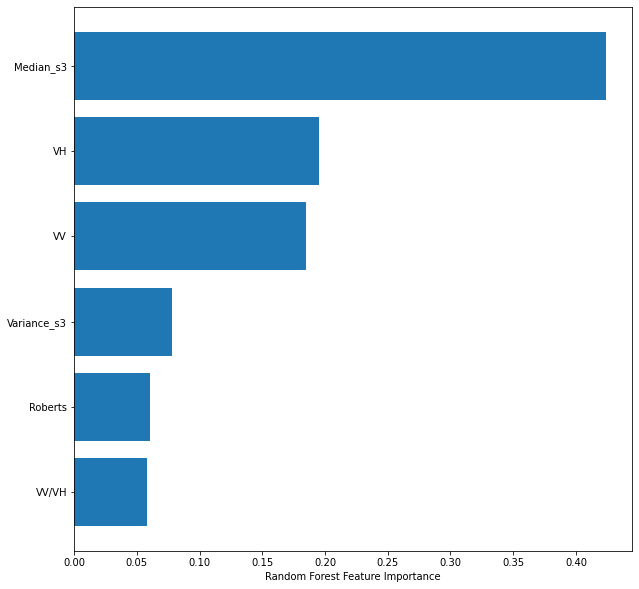

In [ ]:
### Feature Importance ####
# model.feature_importances_

# plt.barh(image_dataset.columns, model.feature_importances_)
fig=plt.figure(figsize=(10,10))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
# plt.margins(x=0, y=-0.10) 
plt.xlabel("Random Forest Feature Importance")

In [ ]:
##########################################################
#STEP 6: SAVE MODEL FOR FUTURE USE
###########################################################

##Save the trained model as pickle string to disk for future use
model_name = "RF_S1Hand"
pickle.dump(model, open(model_name, 'wb'))
#
##To test the model on future datasets
#loaded_model = pickle.load(open(model_name, 'rb'))

Classification Map - Visual Validation

In [ ]:
def feature_extraction(imge):
  image_dataset = pd.DataFrame()  #Dataframe to capture image features

  img_path = "S1Hand/" ## CHANGE ME!!!
  df = pd.DataFrame()  #Temporary data frame to capture information for each loop.
  img = imread(img_path+imge)

  vv = imread(img_path + imge)[0:1,:,:].reshape((128,128)) 
  vh = imread(img_path + imge)[1:2:,:,:].reshape((128,128))
  vv_vh = (vv/vh)
 
  # Add pixel values to the data frame
  vv_values = vv.reshape(-1)
  df['VV'] = vv_values   #Pixel value itself as a feature
            
  vh_values = vh.reshape(-1)
  df['VH'] = vh_values   
  # df['Image_Names1']=image          
  vv_vh_values = vv_vh.reshape(-1)
  df['VV/VH'] = vv_vh_values   

  # MEDIAN with sigma=3
  median_img = nd.median_filter(vh, size=3)
  median_img1 = median_img.reshape(-1)
  df['Median_s3'] = median_img1

  # VARIANCE with size=3
  variance_img = nd.generic_filter(vh, np.var, size=3)
  variance_img1 = variance_img.reshape(-1)
  df['Variance_s3'] = variance_img1  

  # ROBERTS EDGE
  edge_roberts = roberts(vh)
  edge_roberts1 = edge_roberts.reshape(-1)
  df['Roberts'] = edge_roberts1

  ######################################                    
  #Update dataframe for images to include details for each image in the loop
  image_dataset = image_dataset.append(df)
  return df

Bolivia_23014_S1Hand_0384512128.tif
(16384, 6)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


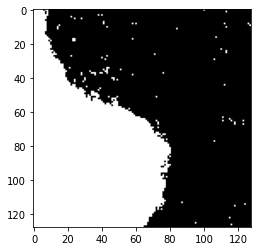

In [ ]:
# Plot  a Predicted sample image
img1 = sources[6]
print(img1)
X = feature_extraction(img1)
print(X.shape)
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
result = model.predict(X_scaled)
segmented = result.reshape((128,128))
plt.imshow(segmented, cmap='gist_gray')

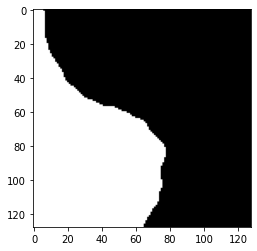

In [ ]:
# Plot the corresponding ground truth label
label1 = label[6]
mask_path = "S1OtsuLabelHand/"
input_mask = imread(mask_path + label1)

plt.imshow(input_mask, cmap='gist_gray')